In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [400]:
import os

import bs4
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Songti SC'] # windows 替换成 SimHei
plt.rcParams['axes.unicode_minus'] = False


In [ ]:
API_URL = "https://api.bilibili.com/x/space/arc/search"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.92 Safari/537.36 Edg/81.0.416.53"
}

PARAMS = {
    "mid": "250858633",
    "ps": "30",
    "tid": "0",
    "pn": "1",
    "order": "pubdate",
    "jsonp": "jsonp"
}


sess = requests.sessions.Session()

def query(page):
    """query api data"""
    global sess
    PARAMS.update(pn=str(page))

    response = sess.get(
        url=API_URL,
        headers=HEADERS,
        params=PARAMS,
    )


    def stats(bvid: str):
        response = sess.get(
            f"https://www.bilibili.com/video/{bvid}",
            headers=HEADERS,
        )
        info = {}
        if response.status_code == requests.codes.ok:
            soup = bs4.BeautifulSoup(response.content)

            try:
                info["rank"] = soup.select_one(".video-data .rank").text.strip()
            except AttributeError:
                info["rank"] = "0"

            nodes = soup.select_one(".ops")
            info["like"] = nodes.select_one(".like").text.strip()
            info["coin"] = nodes.select_one(".coin").text.strip()
            info["collect"] = nodes.select_one(".collect").text.strip()
            info["share"] = nodes.select_one(".share").text.strip()


            return info

    if response.status_code == requests.codes.ok:
        jsons = response.json()["data"]["list"]["vlist"]
        for json in jsons:
            info = stats(bvid=json["bvid"])
            json.update(info)
        return jsons

def parse(jsons):
    """normalize json data"""
    data = [pd.json_normalize(record) for record in jsons]
    return pd.concat(data, ignore_index=True)


data = parse([query(page) for page in range(1, 15)])
sess.close()


In [ ]:
data.to_csv(os.path.expanduser("~/Desktop/data.csv"), index=False)

In [161]:
data = pd.read_csv("/Users/Bobot/Desktop/data.csv")

In [162]:
data.head()

comment  typeid     play  \
0     2733     214   566563   
1     2869      21   685897   
2     3153     214  1331861   
3     4580     214  1408501   
4     3890     214  1445624   

                                                 pic  subtitle  \
0  //i2.hdslb.com/bfs/archive/7277a369123493f02f0...       NaN   
1  //i0.hdslb.com/bfs/archive/5726b33b7e4b1cd7586...       NaN   
2  //i0.hdslb.com/bfs/archive/05bd144323685ce3a29...       NaN   
3  //i0.hdslb.com/bfs/archive/add9e6f89cc83e5f331...       NaN   
4  //i1.hdslb.com/bfs/archive/d08606c29409e4ba85d...       NaN   

                     description  copyright                          title  \
0   华农兄弟：去年种了点金线莲，今年拔点来煲汤，味道很不错哦        NaN   华农兄弟：去年种了点金线莲，今年拔点来煲汤，味道很不错哦   
1      华农兄弟：给大家拜个年，再写副对联贴一下，很漂亮哦        NaN      华农兄弟：给大家拜个年，再写副对联贴一下，很漂亮哦   
2   华农兄弟：养了一年的鱼，是时候抓起来尝一下了，味道好极了        NaN   华农兄弟：养了一年的鱼，是时候抓起来尝一下了，味道好极了   
3                 给兄弟来点菜，感觉还可以哦～        NaN  华农兄弟：最近大鱼大肉吃腻了，去兄弟家搞点菜来招待一下他们   
4  华农兄弟：看一下兄弟养得乌龟，抓2只回去炖汤，味道还可以哦        NaN  华农兄弟：看一下兄弟养得乌龟，抓2只回去炖汤，味道还可以哦   

   review author  ...          bvid  hide_click is_pay  is_union_video  \
0       0   华农兄弟  ...  BV1qN411R776       False      0               0   
1       0   华农兄弟  ...  BV1AA411M71i       False      0               0   
2       0   华农兄弟  ...  BV1jK4y1n7ns       False      0               0   
3       0   华农兄弟  ...  BV1NN411R7Lc       False      0               0   
4       0   华农兄弟  ...  BV1yT4y1P7Hq       False      0               0   

   is_steins_gate         rank   like  coin  collect  share  
0               0            0   6.4万  9430     2439    545  
1               0  全站排行榜最高第83名   9.9万  1.8万     3047   1608  
2               0  全站排行榜最高第62名  10.7万  1.5万     3237   1099  
3               0  全站排行榜最高第47名  12.3万  2.9万     5219   5357  
4               0  全站排行榜最高第65名  11.2万  1.7万     3740   2287  

[5 rows x 25 columns]

In [163]:
# ---------- wrangling ----------
# select
raw: pd.DataFrame = data.loc[
    :,
    [
        "bvid",
        "title",
        "created",
        "length",
        "play",
        "comment",
        "video_review",
        "rank",
        "like",
        "coin",
        "collect",
        "share",
    ],
]


In [164]:
# tidy

def numeric(text: str):
    if "万" in text:
        digits = float(text.replace("万", "")) * 10000
        return int(digits)
    else:
        return int(text)


ops = ["like", "coin", "collect", "share"]

In [165]:
# common
q: pd.DataFrame = (
    raw
    .assign(
        title=raw["title"].str.replace("华农兄弟[：:]", ""),
        created=raw["created"].apply(pd.to_datetime, unit="s"),
        rank=(raw["rank"].str.extract("(?P<rank>\d+)")
              .astype(int)
              .loc[:, "rank"]
              .apply(lambda v: np.nan if v==0 else v)),
    )
    .drop([*ops, "length"], axis=1)
)

# number
n: pd.DataFrame = raw[ops].applymap(numeric)

# length
t: pd.DataFrame = (
    raw["length"]
    .str.extract("(?P<minute>\d+):(?P<second>\d+)")
    .astype(int)
    .assign(seconds=lambda df: df["minute"]*60+df["second"])
    .loc[:, "seconds"]
)

# combine
df = pd.concat([q, t, n], axis=1)

In [166]:
df.head()

bvid                     title             created     play  \
0  BV1qN411R776   去年种了点金线莲，今年拔点来煲汤，味道很不错哦 2021-02-14 03:30:12   566563   
1  BV1AA411M71i      给大家拜个年，再写副对联贴一下，很漂亮哦 2021-02-11 12:00:18   685897   
2  BV1jK4y1n7ns   养了一年的鱼，是时候抓起来尝一下了，味道好极了 2021-02-08 03:30:19  1331861   
3  BV1NN411R7Lc  最近大鱼大肉吃腻了，去兄弟家搞点菜来招待一下他们 2021-02-06 10:00:06  1408501   
4  BV1yT4y1P7Hq  看一下兄弟养得乌龟，抓2只回去炖汤，味道还可以哦 2021-02-05 03:30:11  1445624   

   comment  video_review  rank  seconds    like   coin  collect  share  
0     2733          6864   NaN      557   64000   9430     2439    545  
1     2869          6046  83.0      126   99000  18000     3047   1608  
2     3153         14663  62.0      464  107000  15000     3237   1099  
3     4580         31626  47.0      620  123000  29000     5219   5357  
4     3890         20315  65.0      697  112000  17000     3740   2287

In [167]:
df.dtypes

bvid                    object
title                   object
created         datetime64[ns]
play                     int64
comment                  int64
video_review             int64
rank                   float64
seconds                  int64
like                     int64
coin                     int64
collect                  int64
share                    int64
dtype: object

In [168]:
df.describe(datetime_is_numeric=True)

created          play       comment  \
count                            401  4.010000e+02    401.000000   
mean   2019-08-27 20:28:55.673316864  2.436946e+06   4943.541147   
min              2018-08-23 04:13:38  2.967010e+05    468.000000   
25%              2018-11-11 13:23:49  1.636143e+06   2834.000000   
50%              2019-08-15 09:30:42  2.172133e+06   4342.000000   
75%              2020-04-30 03:35:32  2.838415e+06   5870.000000   
max              2021-02-14 03:30:12  1.592277e+07  88314.000000   
std                              NaN  1.447658e+06   5132.035420   

        video_review        rank      seconds           like           coin  \
count     401.000000  306.000000   401.000000     401.000000     401.000000   
mean    26102.374065   20.068627   419.371571   99488.319202   27409.558603   
min       601.000000    1.000000    40.000000    5294.000000    1299.000000   
25%     10116.000000    9.000000   218.000000   52000.000000   17000.000000   
50%     20390.000000   16.000000   348.000000  101000.000000   23000.000000   
75%     34399.000000   26.000000   553.000000  133000.000000   32000.000000   
max    162534.000000   87.000000  1900.000000  655000.000000  544000.000000   
std     23416.607005   15.748178   266.043115   65170.428490   34705.262655   

            collect         share  
count    401.000000    401.000000  
mean    5644.840399   3498.072319  
min      453.000000    160.000000  
25%     3312.000000   1393.000000  
50%     4594.000000   2266.000000  
75%     6376.000000   3820.000000  
max    89000.000000  49000.000000  
std     6205.244682   4262.714186

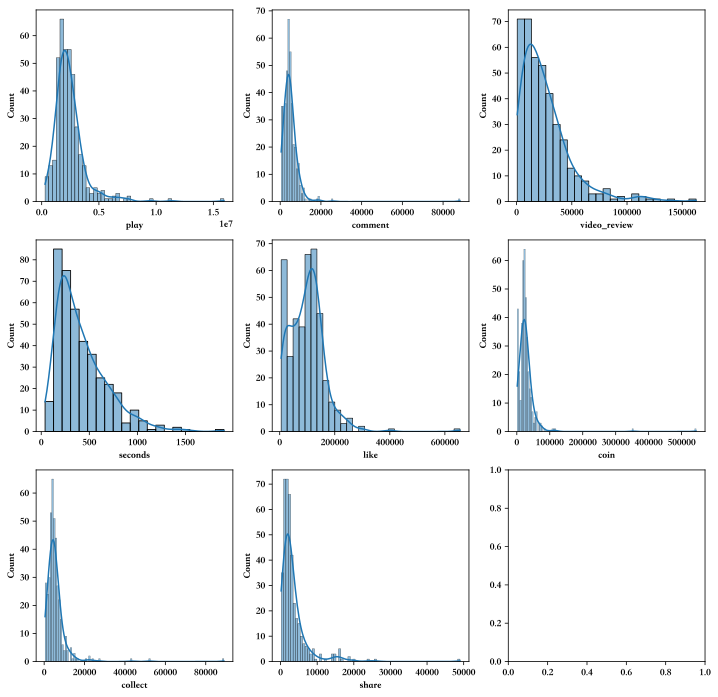

In [356]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        position = i*3+j
        if position != 8:
            sns.histplot(
                x=df.drop(["bvid", "title", "created", "rank"], axis=1).iloc[:,position], 
                ax=ax[i][j],
                kde=True,
                alpha=.5, 
                palette="crest",
            )
    

In [409]:
df.sort_values("rank").query("rank == 1")

bvid                         title             created      play  \
298  BV1rt411C73z      这只香猪老喜欢打架，这样下去不行的，只好把它烤了 2018-11-21 11:06:23  11316046   
292  BV1Ht411q7jD       在路边捡到一只兔子，挺可爱的，放到竹鼠池里养着 2018-12-10 10:15:17   4753297   
49   BV1M64y1F7vy       好久没看过竹鼠棚了，带大家看一下，再喂一下香猪 2020-09-16 03:30:26   6762532   
311  BV1CW41117rS          家里的竹鼠又不够了，去兄弟家再抓一些回来 2018-10-10 03:49:45   2304528   
299  BV17t411U7q2  今年双十一，我们家竹鼠们收到了一份神秘大礼，小白高兴极了 2018-11-12 03:29:43   4113220   

     comment  video_review  rank  seconds    like    coin  collect  share  
298    10230         63322   1.0      276  220000   73000    21000  19000  
292    11110         25927   1.0      249  116000   44000    11000   6013  
49     19126         65185   1.0      553  655000  544000    89000  24000  
311     8000         13202   1.0      200   50000   33000     3259   2837  
299     6879         26763   1.0      310   86000   38000     8633   5881

In [399]:
df.sort_values("seconds", ascending=False).head()

bvid                            title             created  \
186  BV1mJ411K7DJ        抓6只竹鼠去王刚跟山药家玩，尝一下他们烤竹鼠的厨艺 2019-09-27 03:30:17   
10   BV1x54y1s7A6  快过年了，自制了客家美食，叫上兄弟姐妹老人小孩一起吃，其乐融融 2021-01-21 03:30:17   
87   BV1hz411q7Uz            嫩粽叶长出来了，摘点来包粽子，很香很好吃哦 2020-05-23 03:30:12   
90   BV1C54y1X7Hp             去小河里抓点螃蟹来烤，又香又脆，很好吃哦 2020-05-16 03:30:11   
143  BV1dJ411p7Fi         上山砍点竹子，顺便挖几个竹笋回去炒腊肉，很好吃哦 2019-12-25 03:30:43   

        play  comment  video_review  rank  seconds    like   coin  collect  \
186  5826279     8373        115029   5.0     1900  216000  84000    22000   
10   1561789     4911         44248  32.0     1527  128000  37000     6601   
87   1709393     4431         47980  32.0     1433  124000  32000     5080   
90   2532513     5847         79833  21.0     1388  165000  41000     7161   
143  2488927     3610         40472   9.0     1227  122000  38000     6110   

     share  
186  11000  
10    5755  
87    1954  
90    3617  
143   2608

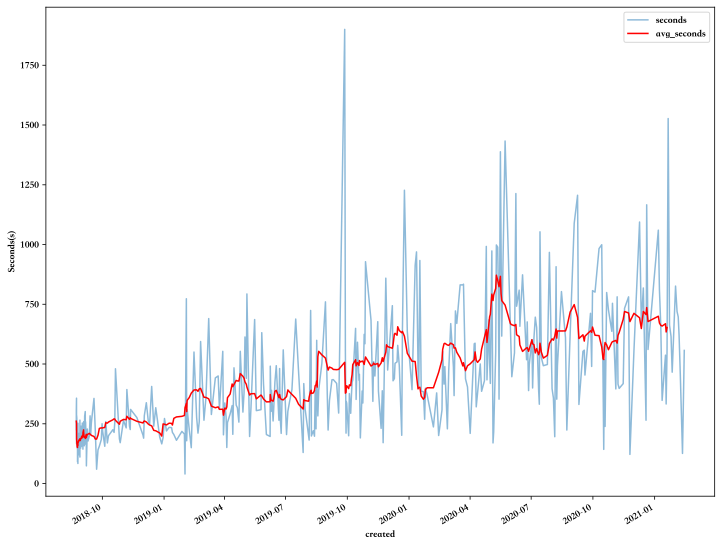

In [419]:
ax = (
    df[["created", "seconds"]]
    .set_index("created")
    .plot.line(
        figsize=(12, 10),
        x_compat=True,
        alpha=0.5,
        xlabel="",
        ylabel="Seconds(s)",
    )
)
(
    df[["created", "seconds"]]
    .set_index("created")
    .rolling(12)
    .mean()
    .rename({"seconds": "avg_seconds"}, axis=1)
    .plot.line(ax=ax, color="red")
)
plt.show()

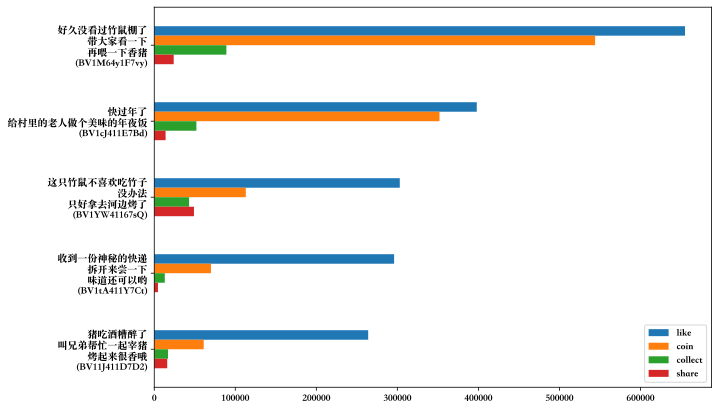

In [421]:
ax = (
    df.loc[:, ["bvid", "title", *ops]]
    .assign(
        title=(
            df["title"].str.replace("(\W+)", "\n")
            + df["bvid"].map(lambda v: "\n({})".format(v))
        )
    )
    .sort_values(ops, ascending=False)
    .head()
    .set_index("title")
    .plot.barh(
        figsize=(10, 7),
        xlabel="",
    )
)

# Revert Rank
ax.invert_yaxis()

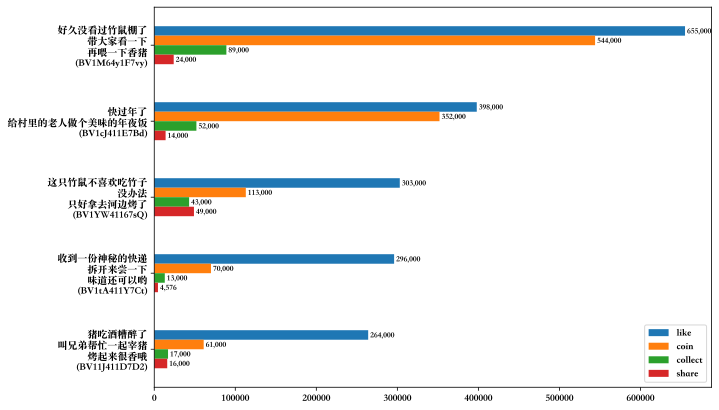

In [422]:
ax = (
    df.loc[:, ["bvid", "title", *ops]]
    .assign(
        title=(
            df["title"].str.replace("(\W+)", "\n")
            + df["bvid"].map(lambda v: "\n({})".format(v))
        )
    )
    .sort_values(ops, ascending=False)
    .head()
    .set_index("title")
    .plot.barh(
        figsize=(10, 7),
        xlabel="",
    )
)

# Revert Rank
ax.invert_yaxis()

# Annotation
for patch in ax.patches:
    ax.text(
        patch.get_width() + 0.3,
        patch.get_y() + 0.1,
        " {:,}".format(patch.get_width()),
        fontsize=8,
        color="black",
    )



In [315]:
df.sort_values(["video_review", "comment"], ascending=False).head()

bvid                            title             created  \
165  BV1pE411Y7dp  参观一下5000亩的赣南脐橙产业园，再找兄弟要一点点脐橙送粉丝 2019-10-28 03:40:03   
241  BV1g4411t742            池子里的鱼太多了，钓一些来煮汤，味道很不错 2019-05-01 13:00:25   
194  BV1L4411q7EV             兄弟来我家，看他最近胖了，烤健身鸡给他吃 2019-08-29 11:00:11   
322  BV1YW41167sQ          这只竹鼠不喜欢吃竹子，没办法，只好拿去河边烤了 2018-09-18 12:51:31   
186  BV1mJ411K7DJ        抓6只竹鼠去王刚跟山药家玩，尝一下他们烤竹鼠的厨艺 2019-09-27 03:30:17   

         play  comment  video_review  rank  seconds    like    coin  collect  \
165   2146363    25774        162534   6.0      928  123000   58000     9606   
241   3636689     8767        138914  17.0      613  133000   67000    11000   
194   5217330    12438        125849   9.0      760  213000   71000    22000   
322  15922772    19085        121119   3.0      356  303000  113000    43000   
186   5826279     8373        115029   5.0     1900  216000   84000    22000   

     share  
165   7052  
241   3342  
194  14000  
322  49000  
186  11000

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

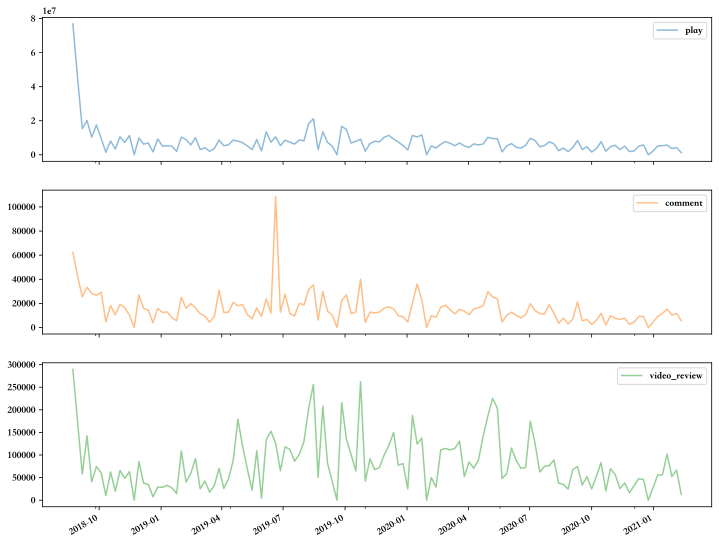

In [348]:
(df.loc[:, "created":"video_review"]
 .set_index("created")
 .resample('7d')
 .sum()
 .plot.line(
     figsize=(12,10),
     alpha=.5,
     x_compat=True,
     xlabel="",
     subplots=True,
 )
)


In [176]:
import jieba.analyse as ja

In [177]:
title = "\n".join(df['title'].tolist())

In [198]:
keywords = ja.extract_tags(
    title, 
    topK=100, 
    withWeight=True, 
    allowPOS=('nr','v','n','ns','vn'),
)

In [199]:
from pyecharts import options as opts
from pyecharts.charts import WordCloud

In [222]:
(
    WordCloud(init_opts=opts.InitOpts(
        height="700px", 
        width="950px",
        bg_color="white",
        )
    )
    .add("", keywords, word_size_range=[25, 80])
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="华农兄弟视频标题关键词TOP100", 
            pos_left="center"
        ),
        toolbox_opts=opts.ToolboxOpts(
            is_show=True, 
            pos_left='center', 
            pos_top="5%",
        ),
    )
    .render(os.path.expanduser("~/Desktop/wordcloud.html"))
)

'/Users/Bobot/Desktop/wordcloud.html'